# Transfer WorkChain to WorkGraph

## Introduction
In this tutorial, we detail how to convert a WorkChain to a WorkGraph, specifically using the [PwBandsWorkChain](https://github.com/aiidateam/aiida-quantumespresso/blob/main/src/aiida_quantumespresso/workflows/pw/bands.py) as a case study. This process can help streamline complex workflows by leveraging WorkGraph's capabilities for better visualization and flexibility.

## Check the Outline of PwBandsWorkChain
First, review the structure of the PwBandsWorkChain to understand its components:

```python
        spec.outline(
            cls.setup,
            if_(cls.should_run_relax)(
                cls.run_relax,
                cls.inspect_relax,
            ),
            if_(cls.should_run_seekpath)(
                cls.run_seekpath,
            ),
            cls.run_scf,
            cls.inspect_scf,
            cls.run_bands,
            cls.inspect_bands,
            cls.results,
        )
```
Each step here can potentially become a task in the WorkGraph.


### Import modules for the Task

Start by importing all required modules and define the necessary tasks for the conversion:



In [1]:
from aiida_workgraph import WorkGraph, task, build_task
from aiida_quantumespresso.workflows.pw.base import PwBaseWorkChain
from aiida_quantumespresso.workflows.pw.relax import PwRelaxWorkChain
from aiida_quantumespresso.calculations.functions.seekpath_structure_analysis import (
    seekpath_structure_analysis,
)

For the `CalcJob` and `WorkChain` (`PwBaseWorkChain` and `PwRelaxWorkChain` in this example), the inputs and outputs of the coopresonding tasks are automatically generated. However, for the [seekpath_structure_analysis](https://github.com/aiidateam/aiida-quantumespresso/blob/main/src/aiida_quantumespresso/calculations/functions/seekpath_structure_analysis.py) calcfunction, it returns a dictionary includes the following keys:


- `parameters`
- `primitive_structure`
- `conv_structure`
- `explicit_kpoints`

We needs to explicitly define the outputs of the `Task` for the `seekpath_structure_analysis`.

In [2]:
# we build a SeekpathTask
# Add only two outputs port here, because we only use these outputs in the following.
SeekpathTask = build_task(
    seekpath_structure_analysis,
    outputs=[["General", "primitive_structure"], ["General", "explicit_kpoints"]],
)

### Create a simple WorkGraph
We can start with the simple case without the `if` conditions, that is to say, we set all the `if_` conditions to `True`.

In the `outline` of the `PwBandsWorkChain`, it also has several `inspect` steps (e.g. `inspect_relax`), which are used to pass data from one step to the next step. In WorkGraph, the dependencies between the tasks are defined automatically by passing the outputs of a task to the inputs of another task.

For example, we pass `relax_task.outputs["output_structure"]` as the `structure` input of the `seekpath_task`, as shown belown.


In [3]:
wg = WorkGraph("Simple Bands Structure")
# ------- relax -----------
relax_task = wg.tasks.new(PwRelaxWorkChain, name="relax")
# -------- seekpath -----------
seekpath_task = wg.tasks.new(SeekpathTask, name="seekpath",
                             structure = relax_task.outputs["output_structure"])
# -------- scf -----------
scf_task = wg.tasks.new(PwBaseWorkChain, name="scf")
scf_task.set({"pw.structure": seekpath_task.outputs["primitive_structure"]})
# -------- bands -----------
bands_task = wg.tasks.new(PwBaseWorkChain, name="bands",
                          kpoints=seekpath_task.outputs["explicit_kpoints"])
bands_task.set({"pw.parent_folder": scf_task.outputs["remote_folder"]})


Visualizing the WorkGraph is also easy.

In [4]:
wg.to_html()
# comment out the following line to visualize the workgraph in jupyter-notebook
# wg


### Create a compelx WorkGraph with `if` conditions

Now, let's enhance our WorkGraph by integrating conditional logic (`if` conditions). We will utilize the `graph_builder` to dynamically construct the WorkGraph based on the `if` conditions.



In [5]:

from aiida_workgraph import WorkGraph, task
from aiida import orm, load_profile

load_profile()

@task.graph_builder()
def bands_workgraph(structure: orm.StructureData = None,
                    run_relax: bool = False,
                    bands_kpoints_distance: float = None) -> WorkGraph:
    """BandsWorkGraph."""
    # Initialize some variables which can be overridden in the following
    bands_kpoints = None
    # Initialize the workgraph
    wg = WorkGraph("Bands Structure with logic")
    # ------- relax -----------
    if run_relax:
        relax_task = wg.tasks.new(PwRelaxWorkChain, name="relax")
        # override the input structure with the relaxed structure
        structure = relax_task.outputs["output_structure"]
    # -------- seekpath -----------
    if bands_kpoints_distance is not None:
        seekpath_task = wg.tasks.new(SeekpathTask, name="seekpath",
                                     structure=structure,
                                     kwargs={"reference_distance": orm.Float(bands_kpoints_distance)},
                                     )
        structure = seekpath_task.outputs["primitive_structure"]
        # override the bands_kpoints
        bands_kpoints = seekpath_task.outputs["explicit_kpoints"]
    # -------- scf -----------
    scf_task = wg.tasks.new(PwBaseWorkChain, name="scf")
    scf_task.set({"pw.structure": seekpath_task.outputs["primitive_structure"]})
    # -------- bands -----------
    bands_task = wg.tasks.new(PwBaseWorkChain, name="bands",
                            kpoints=bands_kpoints)
    bands_task.set({"pw.parent_folder": scf_task.outputs["remote_folder"]})
    return wg

wg = bands_workgraph(run_relax=True, bands_kpoints_distance=0.1)
wg.to_html()
# comment out the following line to visualize the workgraph in jupyter-notebook
# wg


### Adjustments for the inputs of tasks.
Except the explicit link between the tasks, in the `PwBandsWorkChain`, the `inspect` steps are also used to update the input parameters of the next step. For instance, the `inspect_relax` step captures the `current_number_of_bands`, which is then utilized in the `run_scf` step. We need to make some minor adjustments for the inputs of the tasks in the WorkGraph.

#### Handling Common Inputs

Tasks such as `relax`, `scf`, and `bands` often share common inputs like `code` and `pseudos`. These can be defined as inputs of the WorkGraph. One can also generate the inputs by some rule, we load the `pseudos` using `pseudo_family`.

One can also set default values for these inputs, similar to the `get_builder_from_protocol` method in the `PwBandsWorkChain`.


In [6]:
from aiida_workgraph import WorkGraph, task
from aiida import orm

@task()
def inspect_relax(parameters):
    """Inspect relax calculation."""
    return orm.Int(parameters.get_dict()["number_of_bands"])

@task.calcfunction()
def update_scf_parameters(parameters, current_number_of_bands = None):
    """Update scf parameters."""
    parameters = parameters.get_dict()
    parameters.setdefault('SYSTEM', {}).setdefault('nbnd', current_number_of_bands)
    return orm.Dict(parameters)

@task.calcfunction()
def update_bands_parameters(parameters, scf_parameters, nbands_factor=None):
    """Update bands parameters."""
    parameters = parameters.get_dict()
    parameters.setdefault("SYSTEM", {})
    scf_parameters = scf_parameters.get_dict()
    if nbands_factor:
        factor = nbands_factor.value
        nbands = int(scf_parameters["number_of_bands"])
        nelectron = int(scf_parameters["number_of_electrons"])
        nbnd = max(int(0.5 * nelectron * factor), int(0.5 * nelectron) + 4, nbands)
        parameters["SYSTEM"]["nbnd"] = nbnd
    # Otherwise set the current number of bands, unless explicitly set in the inputs
    else:
        parameters["SYSTEM"].setdefault("nbnd", scf_parameters["number_of_bands"])
    return orm.Dict(parameters)

@task.graph_builder()
def bands_workgraph(structure: orm.StructureData = None,
                    code: orm.Code = None,
                    pseudo_family: str = None,
                    pseudos: dict = None,
                    inputs: dict = None,
                    run_relax: bool = False,
                    bands_kpoints_distance: float = None,
                    nbands_factor: float = None,
                    ) -> WorkGraph:
    """BandsWorkGraph."""
    inputs = {} if inputs is None else inputs
    # Initialize some variables which can be overridden in the following
    bands_kpoints = None
    current_number_of_bands = None
    # Load the pseudopotential family.
    if pseudo_family is not None:
        pseudo_family = orm.load_group(pseudo_family)
        pseudos = pseudo_family.get_pseudos(structure=structure)
    # Initialize the workgraph
    wg = WorkGraph("BandsStructure")
    # ------- relax -----------
    if run_relax:
        relax_task = wg.tasks.new(PwRelaxWorkChain, name="relax", structure=structure)
        # retrieve the relax inputs from the inputs, and set the relax inputs
        relax_inputs = inputs.get("relax", {})
        relax_inputs.update({"base.pw.code": code, "base.pw.pseudos": pseudos,})
        relax_task.set(relax_inputs)
        # override the input structure with the relaxed structure
        structure = relax_task.outputs["output_structure"]
        # -------- inspect_relax -----------
        inspect_relax_task = wg.tasks.new(
            inspect_relax,
            name="inspect_relax",
            parameters=relax_task.outputs["output_parameters"],
        )
        current_number_of_bands = inspect_relax_task.outputs["result"]
    # -------- seekpath -----------
    if bands_kpoints_distance is not None:
        seekpath_task = wg.tasks.new(SeekpathTask, name="seekpath",
                                     structure=structure,
                                     kwargs={"reference_distance": orm.Float(bands_kpoints_distance)},
                                     )
        structure = seekpath_task.outputs["primitive_structure"]
        # override the bands_kpoints
        bands_kpoints = seekpath_task.outputs["explicit_kpoints"]
    # -------- scf -----------
    # retrieve the scf inputs from the inputs, and update the scf parameters
    scf_inputs = inputs.get("scf", {"pw": {}})
    scf_parameters = wg.tasks.new(
        update_scf_parameters,
        name="scf_parameters",
        parameters=scf_inputs["pw"].get("parameters", {}),
        current_number_of_bands=current_number_of_bands,
    )
    scf_task = wg.tasks.new(PwBaseWorkChain, name="scf")
    # update inputs
    scf_inputs.update({
            "pw.code": code,
            "pw.structure": structure,
            "pw.pseudos": pseudos,
            "pw.parameters": scf_parameters.outputs[0],
        })
    scf_task.set(scf_inputs)
    # -------- bands -----------
    bands_inputs = inputs.get("bands", {"pw": {}})
    bands_parameters = wg.tasks.new(
        update_bands_parameters,
        name="bands_parameters",
        parameters=bands_inputs["pw"].get("parameters", {}),
        nbands_factor=nbands_factor,
        scf_parameters = scf_task.outputs["output_parameters"],
    )
    bands_task = wg.tasks.new(PwBaseWorkChain, name="bands",
                            kpoints=bands_kpoints)
    bands_inputs.update({
            "pw.code": code,
            "pw.structure": structure,
            "pw.pseudos": pseudos,
            "pw.parent_folder": scf_task.outputs["remote_folder"],
            "pw.parameters": bands_parameters.outputs[0],
        })
    bands_task.set(bands_inputs)
    return wg

wg = bands_workgraph(run_relax=True, bands_kpoints_distance=0.1)
wg.to_html()
# comment out the following line to visualize the workgraph in jupyter-notebook
# wg


### Prepare the inputs and submit the workflow


In [7]:
from copy import deepcopy
from aiida import load_profile
from aiida.orm import Dict, Float, KpointsData, StructureData, load_code
from ase.build import bulk

load_profile()

atoms = bulk('Si')
structure_si = StructureData(ase=atoms)

pw_code = load_code('qe-7.2-pw@localhost')
scf_paras = {
    'CONTROL': {
        'calculation': 'scf',
    },
    'SYSTEM': {
        'ecutwfc': 30,
        'ecutrho': 240,
        'occupations': 'smearing',
        'smearing': 'gaussian',
        'degauss': 0.1,
    },
}
relax_paras = deepcopy(scf_paras)
relax_paras['CONTROL']['calculation'] = 'vc-relax'
bands_paras = deepcopy(scf_paras)
bands_paras['CONTROL']['calculation'] = 'bands'

kpoints = KpointsData()
kpoints.set_kpoints_mesh([3, 3, 3])
#
metadata = {
    'options': {
        'resources': {
            'num_machines': 1,
            'num_mpiprocs_per_machine': 4,
        },
    }
}

bands_inputs = {
    'relax': {
        'base': {
            'pw': {
                'parameters': Dict(relax_paras),
                'metadata': metadata,
            },
            'kpoints': kpoints,
        },
    },
    'scf': {
        'pw': {
            'parameters': Dict(scf_paras),
            'metadata': metadata,
        },
        'kpoints': kpoints,
    },
    'bands': {
        'pw': {
            'parameters': Dict(bands_paras),
            'metadata': metadata,
        },
        'kpoints': kpoints,
    },
}

wg = bands_workgraph(
    structure=structure_si,
    code=pw_code,
    inputs=bands_inputs,
    pseudo_family='SSSP/1.3/PBEsol/efficiency',
    run_relax=True,
    bands_kpoints_distance=0.1,
)
#------------------------- Submit the calculation -------------------
wg.submit(wait=True, timeout=300)


WorkGraph process created, PK: 19272


<WorkChainNode: uuid: b1ff50cc-39ac-4201-b521-6d31318c3691 (pk: 19272) (aiida_workgraph.engine.workgraph.WorkGraphEngine)>

## Plot the band structure

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:ylabel='Dispersion (eV)'>)

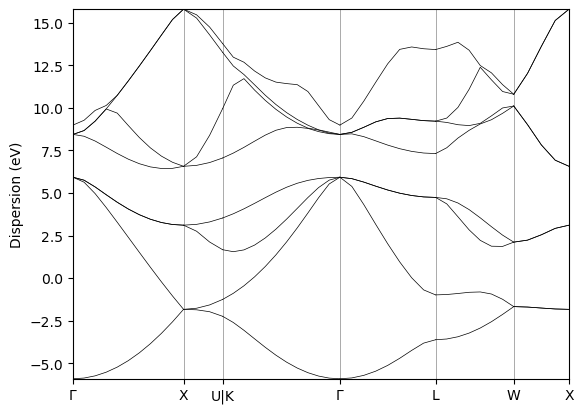

In [8]:
from workgraph_collections.qe.utils import plot_bandstructure
    
bands = wg.tasks["bands"].outputs["output_band"].value
plot_bandstructure(bands)

## Summary

In this tutorial, we began with the `outline` of the PwBandsWorkChain and successfully transitioned it into a WorkGraph. This transformation was carried out in phases, starting from a basic WorkGraph structure, which allowed us to methodically incorporate more complex features.

### Key Steps:
1. **Initial Setup**: Established the fundamental structure by converting each step of the WorkChain outline into corresponding tasks within the WorkGraph.
2. **Integration of Conditional Logic**: Enhanced the WorkGraph's dynamics by integrating conditional flows, enabling the workflow to adapt based on runtime evaluations.
3. **Adjustment of Task Inputs**: Refined the input management for tasks, ensuring that common inputs and parameters like `code` and `pseudos` are optimally configured.



Lastly, here is the final version of the Bands WorkGraph.

<details>
<summary>Bands WorkGraph</summary>


```python
from aiida import orm
from aiida_workgraph import WorkGraph, task, build_task
from aiida_quantumespresso.workflows.pw.base import PwBaseWorkChain
from aiida_quantumespresso.workflows.pw.relax import PwRelaxWorkChain
from aiida_quantumespresso.calculations.functions.seekpath_structure_analysis import (
    seekpath_structure_analysis,
)

# we build a SeekpathTask Node
# Add only two outputs port here, because we only use these outputs in the following.
SeekpathTask = build_task(
    seekpath_structure_analysis,
    outputs=[["General", "primitive_structure"], ["General", "explicit_kpoints"]],
)

@task()
def inspect_relax(parameters):
    """Inspect relax calculation."""
    return orm.Int(parameters.get_dict()["number_of_bands"])

@task.calcfunction()
def update_scf_parameters(parameters, current_number_of_bands = None):
    """Update scf parameters."""
    parameters = parameters.get_dict()
    parameters.setdefault('SYSTEM', {}).setdefault('nbnd', current_number_of_bands)
    return orm.Dict(parameters)

@task.calcfunction()
def update_bands_parameters(parameters, scf_parameters, nbands_factor=None):
    """Update bands parameters."""
    parameters = parameters.get_dict()
    parameters.setdefault("SYSTEM", {})
    scf_parameters = scf_parameters.get_dict()
    if nbands_factor:
        factor = nbands_factor.value
        nbands = int(scf_parameters["number_of_bands"])
        nelectron = int(scf_parameters["number_of_electrons"])
        nbnd = max(int(0.5 * nelectron * factor), int(0.5 * nelectron) + 4, nbands)
        parameters["SYSTEM"]["nbnd"] = nbnd
    # Otherwise set the current number of bands, unless explicitly set in the inputs
    else:
        parameters["SYSTEM"].setdefault("nbnd", scf_parameters["number_of_bands"])
    return orm.Dict(parameters)

@task.graph_builder()
def bands_workgraph(structure: orm.StructureData = None,
                    code: orm.Code = None,
                    pseudo_family: str = None,
                    pseudos: dict = None,
                    inputs: dict = None,
                    run_relax: bool = False,
                    bands_kpoints_distance: float = None,
                    nbands_factor: float = None,
                    ) -> WorkGraph:
    """BandsWorkGraph."""
    inputs = {} if inputs is None else inputs
    # Initialize some variables which can be overridden in the following
    bands_kpoints = None
    current_number_of_bands = None
    # Load the pseudopotential family.
    if pseudo_family is not None:
        pseudo_family = orm.load_group(pseudo_family)
        pseudos = pseudo_family.get_pseudos(structure=structure)
    # Initialize the workgraph
    wg = WorkGraph("BandsStructure")
    # ------- relax -----------
    if run_relax:
        relax_task = wg.tasks.new(PwRelaxWorkChain, name="relax", structure=structure)
        # retrieve the relax inputs from the inputs, and set the relax inputs
        relax_inputs = inputs.get("relax", {})
        relax_inputs.update({"base.pw.code": code, "base.pw.pseudos": pseudos,})
        relax_task.set(relax_inputs)
        # override the input structure with the relaxed structure
        structure = relax_task.outputs["output_structure"]
        # -------- inspect_relax -----------
        inspect_relax_task = wg.tasks.new(
            inspect_relax,
            name="inspect_relax",
            parameters=relax_task.outputs["output_parameters"],
        )
        current_number_of_bands = inspect_relax_task.outputs["result"]
    # -------- seekpath -----------
    if bands_kpoints_distance is not None:
        seekpath_task = wg.tasks.new(SeekpathTask, name="seekpath",
                                     structure=structure,
                                     kwargs={"reference_distance": orm.Float(bands_kpoints_distance)},
                                     )
        structure = seekpath_task.outputs["primitive_structure"]
        # override the bands_kpoints
        bands_kpoints = seekpath_task.outputs["explicit_kpoints"]
    # -------- scf -----------
    # retrieve the scf inputs from the inputs, and update the scf parameters
    scf_inputs = inputs.get("scf", {"pw": {}})
    scf_parameters = wg.tasks.new(
        update_scf_parameters,
        name="scf_parameters",
        parameters=scf_inputs["pw"].get("parameters", {}),
        current_number_of_bands=current_number_of_bands,
    )
    scf_task = wg.tasks.new(PwBaseWorkChain, name="scf")
    # update inputs
    scf_inputs.update({
            "pw.code": code,
            "pw.structure": structure,
            "pw.pseudos": pseudos,
            "pw.parameters": scf_parameters.outputs[0],
        })
    scf_task.set(scf_inputs)
    # -------- bands -----------
    bands_inputs = inputs.get("bands", {"pw": {}})
    bands_parameters = wg.tasks.new(
        update_bands_parameters,
        name="bands_parameters",
        parameters=bands_inputs["pw"].get("parameters", {}),
        nbands_factor=nbands_factor,
        scf_parameters = scf_task.outputs["output_parameters"],
    )
    bands_task = wg.tasks.new(PwBaseWorkChain, name="bands",
                            kpoints=bands_kpoints)
    bands_inputs.update({
            "pw.code": code,
            "pw.structure": structure,
            "pw.pseudos": pseudos,
            "pw.parent_folder": scf_task.outputs["remote_folder"],
            "pw.parameters": bands_parameters.outputs[0],
        })
    bands_task.set(bands_inputs)
    return wg
```
</details>

### Further Learning:
Check out the [workgraph-collections repository](https://github.com/superstar54/workgraph-collections) for practical examples of WorkGraphs tailored to various computational codes.
